In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image


In [2]:
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/imagen-as.png

--2020-08-30 04:36:07--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/imagen-as.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15498 (15K) [image/png]
Saving to: ‘imagen-as.png.3’

imagen-as.png.3     100%[===================>]  15.13K  --.-KB/s    in 0.01s   

2020-08-30 04:36:07 (1.21 MB/s) - ‘imagen-as.png.3’ saved [15498/15498]



(177, 142)


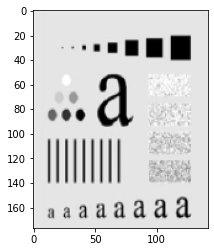

In [3]:
img = cv2.imread('imagen-as.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
print(img.shape)

In [4]:
# Low pass filter promediador
mask = np.full((5, 5), 1)
print(mask)

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


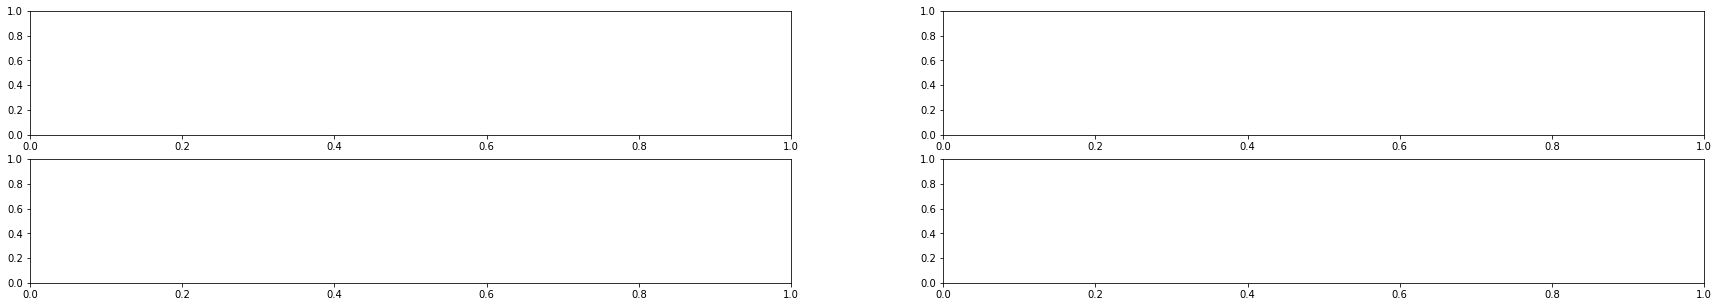

In [5]:
def low_pass_filter(img, dim=3, type="prom"):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2
    def compute_mask(sub_img, x, y):
      val = 0
      if type == "prom":
        mask = np.full((dim, dim), 1)
      if type == "pond":
        mask = np.array([
                         [1, 2, 1],
                         [2, 4 ,2],
                         [1, 2, 1]
                        ])
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val / dim**2

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img


figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(30, 5))

In [6]:
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/black-sky.png

--2020-08-30 04:36:08--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/black-sky.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50074 (49K) [image/png]
Saving to: ‘black-sky.png.3’

black-sky.png.3     100%[===================>]  48.90K  --.-KB/s    in 0.03s   

2020-08-30 04:36:08 (1.88 MB/s) - ‘black-sky.png.3’ saved [50074/50074]



(320, 238)


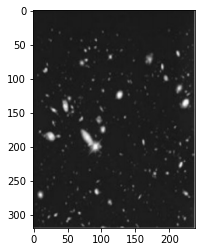

In [7]:
black_sky = cv2.imread('black-sky.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(black_sky , cmap='gray', vmin=0, vmax=255)
print(black_sky .shape)

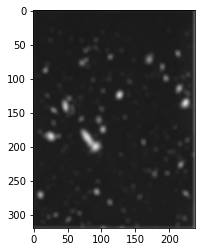

In [8]:
black_sky_blur = low_pass_filter(black_sky, 7)
plt.imshow(black_sky_blur , cmap='gray', vmin=0, vmax=255)


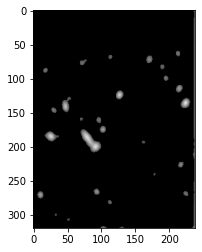

In [9]:
def apply_threshold(img, percentage):
  new_img = np.zeros((img.shape[0], img.shape[1]))
  assert 0 < percentage < 1
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if img[i][j] > percentage*255:
          new_img[i][j] = img[i][j]
  return new_img

black_sky_blur_th = apply_threshold(black_sky_blur, 0.3)
plt.imshow(black_sky_blur_th , cmap='gray', vmin=0, vmax=255)


In [10]:
!wget https://github.com/newtonis/tps_imagenes/blob/master/tp2/filtros/eight.tif

--2020-08-30 04:36:13--  https://github.com/newtonis/tps_imagenes/blob/master/tp2/filtros/eight.tif
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘eight.tif.1’

eight.tif.1             [ <=>                ]  79.03K  --.-KB/s    in 0.03s   

2020-08-30 04:36:14 (2.84 MB/s) - ‘eight.tif.1’ saved [80927]



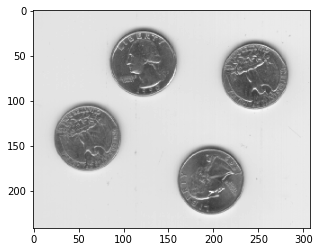

In [11]:
img = Image.open('eight.tif')
coins = np.array(img)
plt.imshow(coins, cmap='gray', vmin=0, vmax=255)

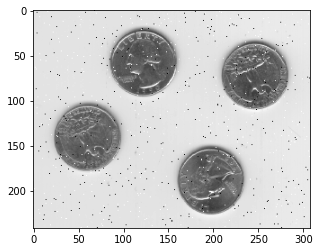

In [12]:
import random
def salt_and_pepper_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

coins_with_salt_and_pepper = salt_and_pepper_noise(coins, 0.005)
plt.imshow(coins_with_salt_and_pepper, cmap='gray', vmin=0, vmax=255)

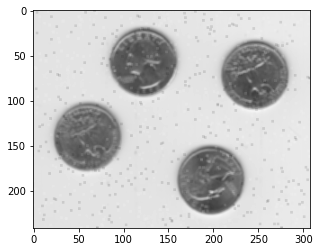

In [13]:
coins_sp_low_pass = low_pass_filter(coins_with_salt_and_pepper, dim=3, type="prom")
plt.imshow(coins_sp_low_pass, cmap='gray', vmin=0, vmax=255)

In [14]:
def median_filter(img, dim=3):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2

    def compute_mask(sub_img, x, y):
      val = 0
      mask = sub_img[x:x+dim, y:y+dim]
      mask = mask.flatten()
      mask = sorted(mask)
      while len(mask) > 1:
        if len(mask) > 1:
          mask = mask[1:]
        if len(mask) > 1:
          mask = mask[:-1]
      return mask[0]

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)

    return new_img

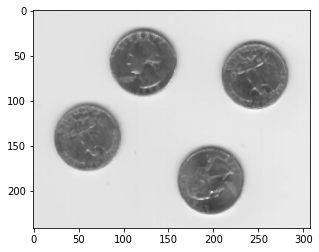

In [15]:
coins_sp_median = median_filter(coins_with_salt_and_pepper, 3)
plt.imshow(coins_sp_median, cmap='gray', vmin=0, vmax=255)

In [16]:
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/moon.png

--2020-08-30 04:36:16--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp2/filtros/moon.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272000 (266K) [image/png]
Saving to: ‘moon.png.1’

moon.png.1          100%[===================>] 265.62K  --.-KB/s    in 0.05s   

2020-08-30 04:36:17 (4.72 MB/s) - ‘moon.png.1’ saved [272000/272000]



(852, 827)


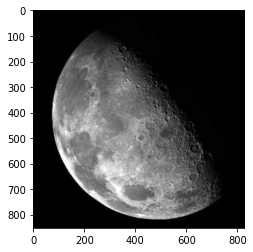

In [17]:
moon = cv2.imread('moon.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(moon, cmap='gray', vmin=0, vmax=255)
print(moon.shape)

In [18]:
  def laplaciano_high_pass(img, dim=3):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2
    print(pad)
    def compute_mask(sub_img, x, y):
      val = 0
      mask = np.array([
                      [1, 1, 1],
                      [1, -8 ,1],
                      [1, 1, 1]
                      ])
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img


1


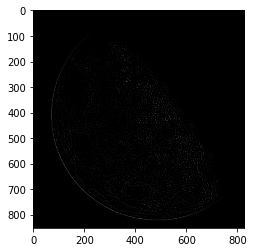

In [19]:
moon_laplaciano = laplaciano_high_pass(moon)
plt.imshow(moon_laplaciano, cmap='gray', vmin=0, vmax=255)

In [20]:
  def laplaciano_con_fondo(img, dim=3):
    assert dim%2 != 0
    new_img = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2
    print(pad)
    def compute_mask(sub_img, x, y):
      val = 0
      mask = np.array([
                      [-1, -1, -1],
                      [-1, 9 , -1],
                      [-1, -1, -1]
                      ])
      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val

    dummy_img = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        new_img[i][j] = compute_mask(dummy_img, i, j)
    
    return new_img

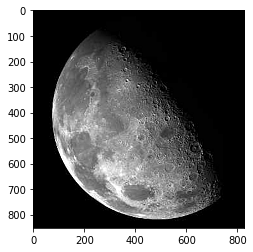

In [21]:
moon_laplaciano_con_fondo = laplaciano_con_fondo(moon)
plt.imshow(moon_laplaciano_con_fondo, cmap='gray', vmin=0, vmax=255)